In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [202]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22740, 3]) torch.Size([22740])
torch.Size([22826, 3]) torch.Size([22826])


In [203]:
letter_emb_size = 2
embedding_context_size = block_size * letter_emb_size

In [221]:
# Init Parameters
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, letter_emb_size), generator=g)
W1 = torch.randn((embedding_context_size, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0
W3 = torch.randn((embedding_context_size, 27), generator=g) * 0.01 # Implement embedding direct to output
parameters = [C, W1, b1, W2, b2, W3]

In [222]:
sum(p.nelement() for p in parameters) # number of parameters in total

7043

In [223]:
for p in parameters:
  p.requires_grad = True

In [224]:
lre = torch.linspace(-3, 0, 10000)
lrs = 10**lre

In [225]:
lri = []
lossi = []
stepi = []

In [226]:
# Initial loss
emb = C[Xtr] # (32, 3, 10)
x = emb.view(-1, embedding_context_size)
h = torch.tanh(x @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 + x @ W3 # (32, 27), incl. new direct connection to output layer
loss = F.cross_entropy(logits, Ytr)
loss

tensor(3.3119, grad_fn=<NllLossBackward0>)

In [210]:
for i in range(300000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  x = emb.view(-1, embedding_context_size)
  h = torch.tanh(x @ W1 + b1) # (64, 200)
  logits = h @ W2 + b2 + x @ W3 # (64, 27), incl. new direct connection to output layer
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  # lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

1.9720650911331177


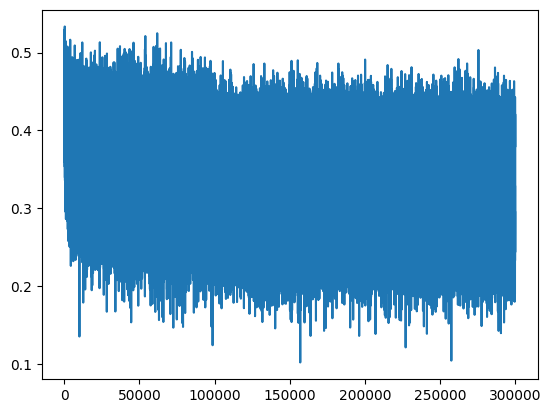

In [215]:
plt.plot(stepi, lossi)

In [216]:
emb = C[Xtr] # (32, 3, 10)
x = emb.view(-1, embedding_context_size)
h = torch.tanh(x @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 + x @ W3 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1378, grad_fn=<NllLossBackward0>)

In [217]:
emb = C[Xdev] # (32, 3, 2)
x = emb.view(-1, embedding_context_size)
h = torch.tanh(emb.view(-1, embedding_context_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 + x @ W3 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1787, grad_fn=<NllLossBackward0>)

In [218]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      x = emb.view(1, -1)
      h = torch.tanh(x @ W1 + b1)
      logits = h @ W2 + b2 + x @ W3
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmahzamille.
khi.
mili.
taty.
skanden.
jazhiel.
delynn.
jarqui.
ner.
kia.
chaiir.
kaleigh.
ham.
por.
desinn.
shoin.
alian.
quisaelo.
dearyn.
kar.
